In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5
import warnings
warnings.filterwarnings("ignore")

from fbprophet import Prophet


Importing plotly failed. Interactive plots will not work.


In [2]:
from data_processing import process_data

REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

production = pd.read_csv('palm_oil_data/production_good.csv')
rainfall = pd.read_csv('palm_oil_data/rainfall_good.csv')
area = pd.read_csv('palm_oil_data/area_good.csv')
RAINFALL_LAGS = [13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]
PRODUCTION_LAGS = [13, 14, 15, 16, 17]
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)
ts = DATA['Johor'][1]
dates = DATA['Johor'][0].index
ts

1999-06-01    210.553
1999-07-01    223.731
1999-08-01    224.397
1999-09-01    234.327
1999-10-01    237.426
               ...   
2017-05-01    225.834
2017-06-01    205.989
2017-07-01    284.963
2017-08-01    293.140
2017-09-01    295.578
Name: Production, Length: 220, dtype: float64

In [5]:
val_interval = 12

train_index = ts.index[:-val_interval]
test_index = ts.index[-val_interval:]

train_val = ts.values[:-val_interval]
test_val = ts.values[-val_interval:]

ptrain = pd.DataFrame()
ptrain["ds"] = train_index
ptrain["y"] = train_val

ptrain['floor'] = ptrain['y'].min()
ptrain['cap'] = ptrain['y'].max() + (ptrain['y'].max() *0.2)

# ptrain['floor']=0
# ptrain['cap']=8000
ptrain

,ds,y,floor,cap
0,1999-06-01,210.553,140.047,395.382
1,1999-07-01,223.731,140.047,395.382
2,1999-08-01,224.397,140.047,395.382
3,1999-09-01,234.327,140.047,395.382
4,1999-10-01,237.426,140.047,395.382
...,...,...,...,...
203,2016-05-01,207.485,140.047,395.382
204,2016-06-01,229.105,140.047,395.382
205,2016-07-01,232.726,140.047,395.382
206,2016-08-01,264.981,140.047,395.382


In [6]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

In [13]:
cutoffs = pd.to_datetime(['2001-09-01', '2003-09-01', '2006-09-01', '2009-09-01', '2011-09-01','2012-09-01', '2014-09-01', '2016-09-01'])
cutoffs

DatetimeIndex(['2001-09-01', '2003-09-01', '2006-09-01', '2009-09-01',
               '2011-09-01', '2012-09-01', '2014-09-01', '2016-09-01'],
              dtype='datetime64[ns]', freq=None)

In [19]:
import itertools
import numpy as np
import pandas as pd

# search through some hyperparams to get the best value:
param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }

cutoffs = pd.to_datetime(['2001-09-01', '2003-09-01', '2006-09-01', '2009-09-01', '2011-09-01','2012-09-01', '2013-08-15', '2014-02-01', '2015-09-01'])
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs and MAPEs for each params here
mapes = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(ptrain)  # Fit model with given params
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='365 days', parallel="processes")
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])
    mapes.append(df_p['mape'].values[0])



INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000025E52687248>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000025E5263E7C8>
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x0000025E5264A488>
INFO:fbprophet:Disabling 

In [ ]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
tuning_results['mape'] = mapes

In [45]:
best_params = all_params[np.argmin("")]
best_params['growth'] = "linear"
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive', 'growth': 'linear'}


In [ ]:
param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }


In [46]:
# final model:
m_final = Prophet(    
                **best_params,
                yearly_seasonality=True,
                daily_seasonality=True
            )
m_final.fit(ptrain)  # Fit model with given params

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [47]:
future = m_final.make_future_dataframe(periods=12, include_history=True, freq="m")
future['floor'] = ptrain['y'].min()
future['cap'] = ptrain['y'].max() + (ptrain['y'].max() *0.2)

forecast = m_final.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# fig1 = m.plot(forecast)

,ds,yhat,yhat_lower,yhat_upper
0,1999-06-01,200.776654,170.615202,233.917972
1,1999-07-01,209.579829,175.996332,241.912233
2,1999-08-01,213.893144,180.879388,246.072153
3,1999-09-01,221.000640,188.044832,254.253121
4,1999-10-01,224.698044,194.745631,257.575448
...,...,...,...,...
215,2017-04-30,261.579184,230.129724,295.353407
216,2017-05-31,265.232313,236.726661,296.345319
217,2017-06-30,274.405282,244.192066,308.574003
218,2017-07-31,278.968826,247.165116,311.543968


In [48]:
yhat = forecast['yhat'][-val_interval:]
forecast['ds'][-val_interval:]


208   2016-09-30
209   2016-10-31
210   2016-11-30
211   2016-12-31
212   2017-01-31
213   2017-02-28
214   2017-03-31
215   2017-04-30
216   2017-05-31
217   2017-06-30
218   2017-07-31
219   2017-08-31
Name: ds, dtype: datetime64[ns]

In [49]:
# fig = m.plot_components(forecast)
# WMAPE metric
def wmape(y, y_hat):
    return np.abs((y - y_hat)).sum() / y.sum()
# RMSE metric
def rmse(y, y_hat):
    return np.sqrt(((y - y_hat) ** 2).mean())

In [50]:
forecast.set_index("ds")

,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,,,,,
1999-06-01,196.918813,395.382,170.615202,233.917972,196.918813,196.918813,3.857841,3.857841,3.857841,0.012677,0.012677,0.012677,3.845164,3.845164,3.845164,0.0,0.0,0.0,200.776654
1999-07-01,197.214802,395.382,175.996332,241.912233,197.214802,197.214802,12.365027,12.365027,12.365027,0.012677,0.012677,0.012677,12.352350,12.352350,12.352350,0.0,0.0,0.0,209.579829
1999-08-01,197.520658,395.382,180.879388,246.072153,197.520658,197.520658,16.372486,16.372486,16.372486,0.012677,0.012677,0.012677,16.359810,16.359810,16.359810,0.0,0.0,0.0,213.893144
1999-09-01,197.826513,395.382,188.044832,254.253121,197.826513,197.826513,23.174127,23.174127,23.174127,0.012677,0.012677,0.012677,23.161450,23.161450,23.161450,0.0,0.0,0.0,221.000640
1999-10-01,198.122502,395.382,194.745631,257.575448,198.122502,198.122502,26.575542,26.575542,26.575542,0.012677,0.012677,0.012677,26.562865,26.562865,26.562865,0.0,0.0,0.0,224.698044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-30,261.474056,395.382,230.129724,295.353407,261.474056,261.474057,0.105127,0.105127,0.105127,0.012677,0.012677,0.012677,0.092451,0.092451,0.092451,0.0,0.0,0.0,261.579184
2017-05-31,261.779912,395.382,236.726661,296.345319,261.779912,261.779912,3.452401,3.452401,3.452401,0.012677,0.012677,0.012677,3.439724,3.439724,3.439724,0.0,0.0,0.0,265.232313
2017-06-30,262.075901,395.382,244.192066,308.574003,262.075901,262.075901,12.329381,12.329381,12.329381,0.012677,0.012677,0.012677,12.316704,12.316704,12.316704,0.0,0.0,0.0,274.405282


In [51]:
from metrics import rmse, wmape
print(rmse(yhat, test_val), wmape(yhat, test_val))
forecast['ds']
forecast['yhat']
x = pd.DataFrame(forecast['yhat'], forecast['ds'])
x['yhat'] = forecast['yhat']
x

26.301846702364355 0.07825938932096048


,yhat
ds,
1999-06-01,NaN
1999-07-01,NaN
1999-08-01,NaN
1999-09-01,NaN
1999-10-01,NaN
...,...
2017-04-30,NaN
2017-05-31,NaN
2017-06-30,NaN


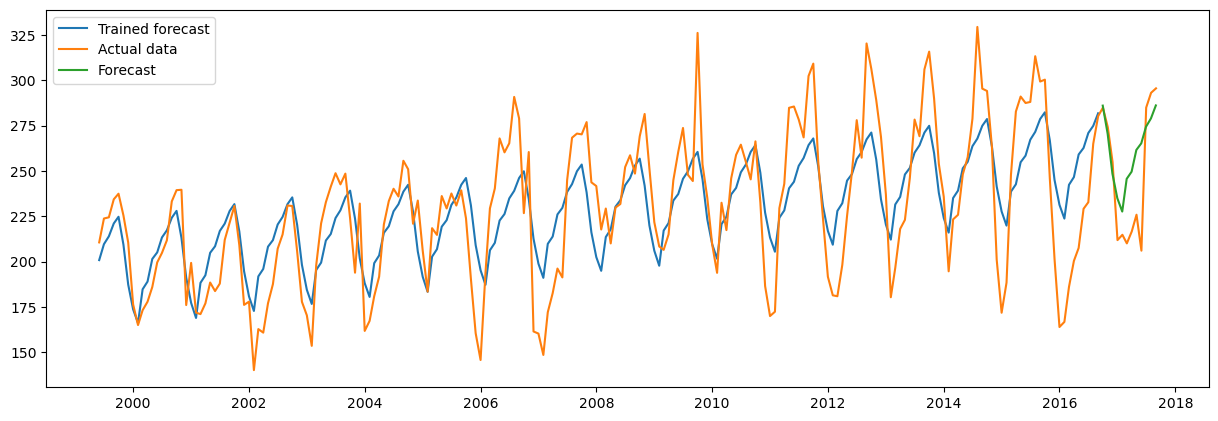

In [52]:
plt.plot(forecast['ds'][:-12], forecast['yhat'][:-12], label="Trained forecast")
plt.plot(DATA['Johor'][1], label="Actual data")
plt.plot(forecast['ds'][-12:], forecast['yhat'][-12:], label="Forecast")
plt.legend()

We het pretty decent results by making a lot less effort than in ML, or DL!!

